In [86]:
"""
Testing loading a saved model and running the test_generate function
"""
import os
current_directory = os.getcwd()
os.chdir('/home/maccyz/Documents/LLM_Fluid')
new_directory = os.getcwd()
print("New Directory:", new_directory)

import logging
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from cprint import c_print
import numpy as np

from utils import set_seed, load_yaml_from_file, get_available_device, get_save_folder, get_accelerator
from utils_model import calc_n_rmse, patch_to_img, get_data_loader
from models.model import MultivariateTimeLLM

from dataloader.synthetic.synth_dl import SynthDS

logging.basicConfig(level=logging.INFO,
                    format=f'[{__name__}:%(levelname)s] %(message)s')


def get_eval_dl(model, bs, seq_len):
    ds = SynthDS(
        patch_size=model.config['patch_size'],
        stride=model.config['stride'],
        seq_len=seq_len,
        mode='valid',
    )

    dl = DataLoader(ds, batch_size=bs, num_workers=8, pin_memory=True)
    return dl


def plot_set(plot_step, true_states, pred_states, title):
    true_states, pred_states = true_states[plot_step].cpu(), pred_states[plot_step].cpu()
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 9))
    fig.suptitle(f'{title}')
    for i, ax in enumerate(axs):
        img_1 = true_states[i]
        img_2 = pred_states[i]
        
        vmin, vmax = img_1.min(), img_1.max()
        print(f'{vmin = }, {vmax = }')
        ax[0].imshow(img_1.T, vmin=vmin, vmax=vmax, cmap='viridis')  # Initial image
        ax[1].imshow(img_2.T, vmin=vmin, vmax=vmax, cmap='viridis')  # Predictions
        ax[0].axis('off'), ax[1].axis('off')
    fig.tight_layout()
    fig.savefig(f'/home/maccyz/Documents/LLM_Fluid/plot_{plot_step}.png')
    fig.show()
    

@torch.inference_mode()
def test_generate(model: MultivariateTimeLLM, dl, plot_step, batch_num=0):
    model.eval()

    start_step = 5
    ctx_states = 5
    pred_steps = 10
    start_cut = start_step - ctx_states
    end_state = pred_steps + ctx_states if ctx_states == 1 else pred_steps + ctx_states - 1

    # Keep the first batch for plotting
    first_batch = None
    N_rmses = []
    # Get batch and run through model
    for i, batch in enumerate(dl):
        # Filter out start
        batch = [b[:, start_cut:] for b in batch]
        batch = [t.cuda() for t in batch]

        states, _, diffs, bc_mask, position_ids = batch

        # bs, seq_len, N_patch, channel, px, py = states.shape
        pred_states, pred_diffs = model.gen_seq(batch, pred_steps=pred_steps-1, start_state=ctx_states)
        pred_states = pred_states[:, :-1]

        # print(f'{pred_states.shape = }')
        # print(pred_states.std(dim=(0, 2, 3, 4)) )

        true_states = patch_to_img(states, model.ds_props)
        true_diffs = patch_to_img(diffs, model.ds_props)
        bc_mask = patch_to_img(bc_mask.float(), model.ds_props).bool()

        true_states = true_states[:, :end_state]
        bc_mask = bc_mask[:, :end_state]
        # print(f'{pred_states.shape = }, {true_states.shape = }, {bc_mask.shape = }')
        N_rmse = calc_n_rmse(pred_states, true_states, bc_mask)
        N_rmses.append(N_rmse)

        if first_batch is None:
            first_batch = (true_states, true_diffs, pred_states, pred_diffs)

        break

    N_rmses = torch.cat(N_rmses, dim=0)
    N_rmse = torch.mean(N_rmses, dim=0)
    first_rmses = torch.mean(N_rmse[:15])
    c_print(f"First 15 N_RMSE: {first_rmses:.3g}", color='green')
    c_print(f"Standard N_RMSE: {N_rmse[ctx_states:]}, Mean: {N_rmse.mean().item():.3g}", color='cyan')

    # Plotting
    plot_nums = np.array([0, pred_steps-2]) + ctx_states
    return first_batch, plot_nums
    # for plot_step in plot_nums:
    #     true_states, true_diffs, pred_states, pred_diffs = first_batch
    # 
    #     # # Plot diffs
    #     # plot_set(plot_step, true_diffs[batch_num], pred_diffs[batch_num], 'Differences')
    # 
    #     # Plot states
    #     plot_set(plot_step, true_states[batch_num], pred_states[batch_num], f'States, step {plot_step-ctx_states}')


def main():
    load_no = -1
    save_epoch = 180
    seq_len = 23
    bs = 16

    plot_step = -1
    plot_batch_num = 0

    set_seed()

    # Load the checkpoint
    load_path = get_save_folder("./model_checkpoints", load_no=load_no)
    checkpoint_file_path = os.path.join(load_path, f'step_{save_epoch}.pth')
    logging.info(f"Loading checkpoint from: {checkpoint_file_path}")

    if not os.path.exists(checkpoint_file_path):
        raise ValueError(f"Checkpoint file not found at {checkpoint_file_path}")

    ckpt = torch.load(checkpoint_file_path)
    ckpt_state_dict = ckpt['state_dict']
    ckpt_params = load_yaml_from_file(f'{load_path}/training1.yaml')
    # ckpt_params['compile'] = False

    # Get dataloader
    ckpt_params['seq_len'] = ckpt_params['autoreg_seq_len']
    _, ds_props = get_data_loader(ckpt_params, mode="valid")

    # Get the model
    model = MultivariateTimeLLM(ckpt_params, ds_props=ds_props, device_map=get_available_device())
    # Load weights
    model.load_state_dict(ckpt_state_dict)
    accelerator = get_accelerator(use_deepspeed=False, precision='bf16')
    model = accelerator.prepare(model)

    # Val dataloader
    dl = get_eval_dl(model, bs, seq_len)

    # Run test_generate
    return test_generate(model, dl, plot_step, plot_batch_num)

a = main()

[utils:INFO] Loading checkpoint from: ./model_checkpoints/synthetic/step_180.pth
[utils:INFO] Loading parameters from: ./model_checkpoints/synthetic/training1.yaml


New Directory: /home/maccyz/Documents/LLM_Fluid
LLM config: OPTConfig {
  "_name_or_path": "facebook/opt-125m",
  "_remove_final_layer_norm": false,
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "OPTForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "do_layer_norm_before": true,
  "dropout": 0.1,
  "enable_bias": true,
  "eos_token_id": 2,
  "ffn_dim": 3072,
  "hidden_size": 768,
  "init_std": 0.02,
  "layer_norm_elementwise_affine": true,
  "layerdrop": 0.0,
  "max_position_embeddings": 2048,
  "model_type": "opt",
  "num_attention_heads": 12,
  "num_hidden_layers": 7,
  "output_attentions": true,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "prefix": "</s>",
  "torch_dtype": "float16",
  "transformers_version": "4.39.2",
  "use_cache": true,
  "vocab_size": 50272,
  "word_embed_proj_dim": 768
}



[utils:INFO] Using LoRA with config: {'r': 16, 'lora_alpha': 64, 'lora_dropout': 0.1, 'bias': 'none', 'use_dora': True}


trainable params: 354,816 || all params: 90,154,752 || trainable%: 0.3935632810569985
First 15 N_RMSE: 0.09
Standard N_RMSE: tensor([0.0207, 0.0336, 0.0453, 0.0825, 0.1262, 0.1710, 0.2157, 0.2603, 0.3048],
       device='cuda:0'), Mean: 0.09


In [ ]:
batch_num = 5

fb, pn = a
true_states, true_diffs, pred_states, pred_diffs = fb
for plot_step in [5, 7, 9, 11,12]:
    plot_set(plot_step, true_states[batch_num], pred_states[batch_num], f'States, step {plot_step-5}')

vmin = -0.9693472862243653, vmax = 1.0079668760299683


/tmp/ipykernel_396314/3599216995.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


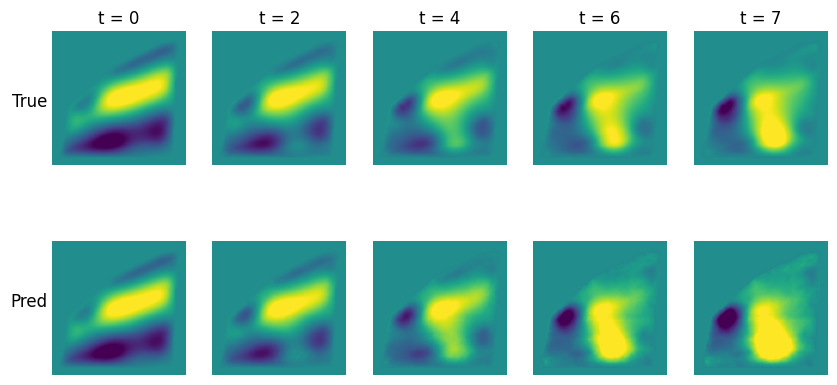

In [116]:
def plot_sequence(true_states, pred_states, step_nos):
    true_states, pred_states = true_states.cpu().numpy(), pred_states.cpu().numpy()
    
    vmin, vmax = true_states[step_nos].min()*0.8, true_states[step_nos].max()*0.5
    print(f'{vmin = }, {vmax = }')
        
    fig, axs = plt.subplots(2, len(step_nos), figsize=(10, 5))
    for i, step_no in enumerate(step_nos):
        true_state = true_states[step_no, 0]
        pred_state = pred_states[step_no, 0]


        axs[0, i].imshow(true_state.T, vmin=vmin, vmax=vmax, cmap='viridis')
        axs[1, i].imshow(pred_state.T, vmin=vmin, vmax=vmax, cmap='viridis')
        
        axs[0, i].set_title(f't = {step_no-5}')
        axs[0, i].axis('off'), axs[1, i].axis('off')
    
    for i, label in enumerate(["True", "Pred"]):
        fig.text(0.12, 0.7 - i*0.4, label, va='center', ha='right', fontsize='large')

    
    # fig.tight_layout()
    fig.savefig(f'/home/maccyz/Documents/LLM_Fluid/plot.png')
    fig.show()
    
batch_num = 10
fb, pn = a
true_states, true_diffs, pred_states, pred_diffs = fb
plot_sequence(true_states[batch_num], pred_states[batch_num], [5, 7, 9, 11, 12])
# for plot_step in [5, 7, 9, 11,]:
#     plot_set(plot_step, true_states[batch_num], pred_states[batch_num], f'States, step {plot_step-5}')